In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from auxiliares import dataframe_coeficientes
from graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet('dados_clean.parquet')

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [7]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

colunas_robust_scaler = df.columns.difference(coluna_target+coluna_one_hot_encoder+coluna_ordinal_encoder) #para colunas com outliers


Como o melhor preprocessamento testado foi o preprocessamento simples, iremos aplicar o procedimento de Features Polinimias apenas neste preprocessor.

In [8]:

pipeline_robust = Pipeline([
    ("robust_scaler", RobustScaler()),  
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])


preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
    remainder="passthrough"
)


In [9]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [10]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [11]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


Insigh: Compensa a transformação de target.

Agora, iremos usar o GridSearch para verificar qual transformação de target é melhor: PowerTransformer() ou QuantileTransformer()

In [12]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha" : [0.01, 0.05, 0.1, 0.25, 0.5, 1],
    "regressor__reg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
}


In [13]:
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(st...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
grid_search.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\tenen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\tenen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e+02, tolerance: 1.758e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(st...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [15]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

L1 ration pequeno, significando que o modelo Elastic Net está muito mais para o Ridge que para o Lasso. OBS: Quanto mais L1 está  para 0, mais ele esta para ridge, e quanto mais ele esta para 1, mais ele esta para Lasso

In [16]:
grid_search.best_score_

np.float64(-51293.57191683493)

In [17]:
coef = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),

)

coef

,coeficiente
one_hot__ocean_proximity_INLAND,-0.596776
robust_scaler_poly__longitude,-0.378432
robust_scaler_poly__population_per_household,-0.339755
robust_scaler_poly__latitude,-0.213848
robust_scaler_poly__latitude^2,-0.190989
...,...
ordinal_encoder__median_income_cat,0.091812
robust_scaler_poly__housing_median_age longitude^2,0.108730
robust_scaler_poly__bedrooms_per_room,0.129127
robust_scaler_poly__housing_median_age median_income,0.179309


In [19]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "ElasticNet_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    }
}


In [20]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\tenen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.250e+01, tolerance: 1.412e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\tenen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.372e+01, tolerance: 1.419e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\tenen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.004527,0.002004,-0.000081,-77516.042766,-96239.705692,0.006531
1,DummyRegressor,0.006307,0.001996,-0.000146,-75787.787194,-95217.629397,0.008303
2,DummyRegressor,0.002001,0.005521,-0.001737,-76753.598961,-96253.253947,0.007522
3,DummyRegressor,0.003999,0.003157,-0.000101,-76837.804811,-95983.885799,0.007155
4,DummyRegressor,0.001001,0.006723,-0.000114,-76617.245449,-96182.764729,0.007724
5,LinearRegression,0.034106,0.008211,0.682162,-39855.690996,-54254.958188,0.042318
6,LinearRegression,0.029046,0.0,0.66999,-40272.565467,-54695.230283,0.029046
7,LinearRegression,0.033667,0.00812,0.649247,-42178.05929,-56955.988706,0.041787
8,LinearRegression,0.046245,0.011362,0.669873,-40806.492497,-55146.318803,0.057607
9,LinearRegression,0.106486,0.013468,0.669023,-40788.496497,-55331.35106,0.119954


In [ ]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003213,0.003492,-0.000284,-76680.711781,-95942.817054,0.006705
ElasticNet_grid_search,16.268032,0.018114,0.715115,-35980.889398,-51194.508743,16.286145
LinearRegression,0.022509,0.007037,0.665435,-40963.417914,-55484.16665,0.029547
LinearRegression_target,0.028321,0.008113,0.675957,-38786.3,-54601.024145,0.036435


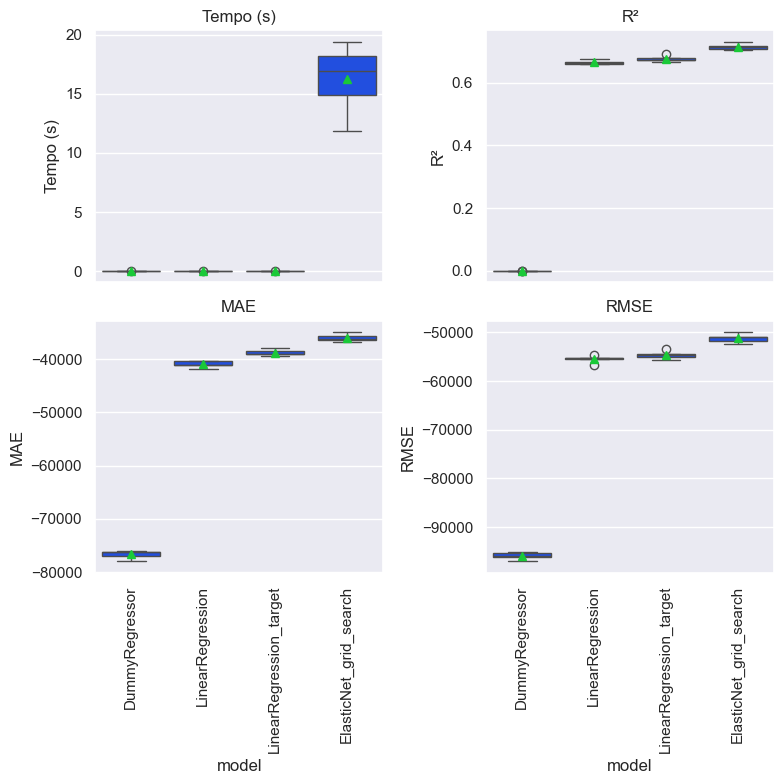

In [ ]:
plot_comparar_metricas_modelos(df_resultados)

In [ ]:
from graficos import plot_residuos_estimador

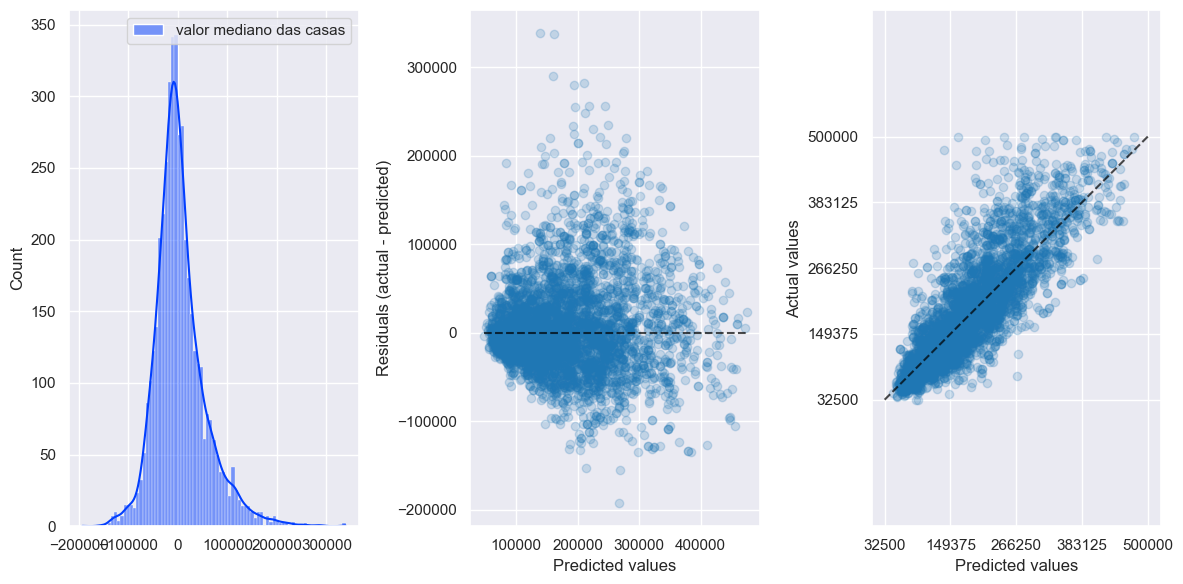

In [ ]:
plot_residuos_estimador(grid_search.best_estimator_, X, y)